# Nonparametric Regression
## Agenda

- Kernel Regressionの紹介
- NW estimator
- Local Linear estimator

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Install Packages

In [4]:
pass

### Import

In [5]:
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st

import statsmodels.api as sm
from statsmodels.nonparametric import kernel_regression

## 1. Nadaraya-Watson 推定量 (Local Constant Estimator)

$\{(Y_1, \mathbf X_1), ..., (Y_n, \mathbf X_n)\}$を分布$F_{Y, X}$からの無作為標本とする。$Y_i$から$\mathbf X_i$への回帰関数は

$$
f(\mathbf x) = \mathbb E[Y_i|\mathbf X_i = \mathbf x]
$$

で定義される。NW推定量のアイデアは

$$
f(\mathbf x) = \int y f_{Y|X}(y|\mathbf x)dy =\int y\frac{f_{Y, X}(y, \mathbf x)}{f_X(\mathbf x)}dy
$$

これをカーネル密度推定を踏まえて定義すると、

$$
\hat f_{NW}(\mathbf x) = \frac{\sum_{i=1}Y_i K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right)}{\sum_{i=1}K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right)}\tag{1}
$$

### Nadaraya-Watson 推定量の導出

$$
\begin{aligned}
\hat f_{Y, X}(y, \mathbf x) &= \frac{1}{nh_0h_1\cdots h_q}\sum_{i=1}k\left(\frac{Y_i - y}{h_0}\right)kK\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right)\\
\hat f_X(\mathbf x)& = \frac{1}{nh_1\cdots h_q}\sum_{i=1}K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right)
\end{aligned}
$$

これを用いると

$$
\frac{1}{h_0}\int y k\left(\frac{Y_i - y}{h_0}\right)dy = \frac{1}{h_0}\int (Y_i - h_0u)k(u)\frac{dy}{du}du = Y_i
$$

なお、詳細は省くが$(Y_1, X_1), ..., (Y_i, X_i), ..., (Y_n, X_n)$ のときのNW estimatorの漸近分散は

$$
{\sf Var} \left(\widehat{f}_n(x)\right) = \frac{\sigma^2(x)}{f(x)\cdot nh}\int K^2(u)du + o\left(\frac{1}{nh}\right),
$$
where $\sigma^2(x) = {\sf Var}(Y|X=x)$.

### Python with statsmodels

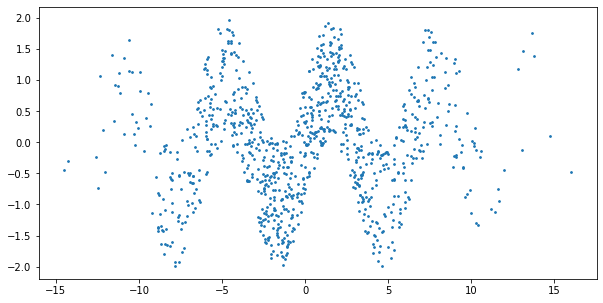

In [6]:
# Generate sample data
X = 5 * np.random.normal(0, 1, 1000)
eps = np.random.uniform(-1, 1, 1000)
y = np.sin(X).ravel() + eps
plt.figure(figsize = (10,5))
plt.scatter(X, y, s = 3);

In [7]:
NW_reg = kernel_regression.KernelReg(y, X, var_type = 'c', reg_type = 'lc')

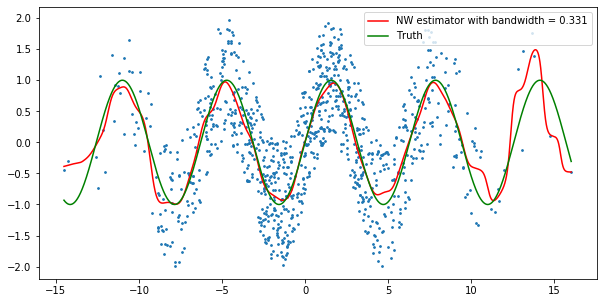

In [8]:
plt.figure(figsize = (10,5))

x_range = np.linspace(min(X), max(X), 10000)
pred = NW_reg.fit(x_range)
true = np.sin(x_range).ravel()

plt.scatter(X, y, s = 3)
plt.plot(x_range, pred[0], c = 'r',  label = 'NW estimator with bandwidth = %.3f' % NW_reg.bw)
plt.plot(x_range, true, c = 'g',  label = 'Truth')
plt.legend();

### NW Estimatorとweighted mean

NW推定量は次のような最小化問題の解としても得られる(Plug-in Method)。

$$
\hat g_{NW}(\mathbf x) = \arg\min_a \sum_{i=1}(Y_i - a)^2K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right)
$$

- この式からもわかるようにNW estimatorは$g(\mathbf x)$を局所的に定数で近似する推定量となっている (= Local Constant estimator)。
- NW推定量はサポート境界近くでのパフォーマンスが悪くなる傾向がある
- pointwise estimatorであることがわかる

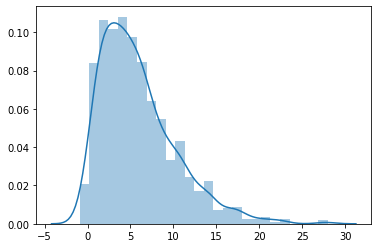

In [9]:
nobs = 1000
np.random.seed(42)

x1 = np.random.normal(size=nobs)
x2 = np.random.normal(2, 1, size=nobs)
X = np.vstack([x1, x2]).T
eps = np.random.uniform(-1, 1, nobs)

y = np.cos(x1) + x2**2 + eps

sns.distplot(y);

In [10]:
def nNW(x, X, Y, h, K = st.norm.pdf):
    # Arguments
    # x: evaluation points, array
    # X: vector (size n) with the predictors
    # Y: vector (size n) with the response variable
    # h: bandwidth, array
    # K: kernel
    Z = (X - x)/h
    Kx =  np.prod(K(Z), axis = 1)
    weight = Kx/sum(Kx)
    
    return np.sum(y * weight)

def silverman_rule(x, d, obs):
    sigma = np.std(x, ddof = 1)
    return (4/(d+2))**(1/(d+4))*obs**(-1/(d+4))*sigma

In [11]:
h1, h2 = silverman_rule(x1, d = 2, obs = nobs), silverman_rule(x2, d = 2, obs = nobs)

In [12]:
pred = np.array([nNW(x = X[i, :], X = X, Y = y, h = np.array([h1, h2])) for i in range(nobs)])

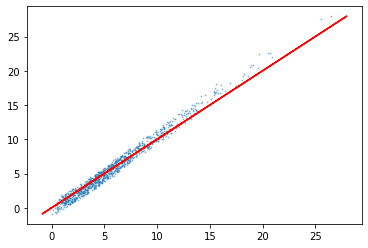

In [13]:
plt.scatter(pred, y, alpha = 0.5, s = .5)
plt.plot(y, y, c = 'r');

## 2. LL推定量

$$
\min \sum_{i=1}(Y_i - a - \beta' (\mathbf X_i - \mathbf x))^2K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h}\right)
$$


この最小化問題の解を$(\hat a(\mathbf x), \hat \beta(\mathbf x))$で表すことにする。$\mathbf Z_i = (1, (X_i - x)')'$とすると

$$
\left(\begin{array}{c}
\hat a(\mathbf x)\\ \hat \beta(\mathbf x)
\end{array}\right) = \left(\sum_{i=1}K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h }\right)\mathbf Z_i\mathbf Z_i'\right)^{-1}\sum_{i=1}K\left(\frac{\mathbf X_i - \mathbf x}{\mathbf h }\right)\mathbf Z_iY_i
$$

- $\hat a(\mathbf x)$がLL推定量$\hat g_{LL}(\mathbf x)$である。
- $\hat \beta(\mathbf x)$は$dg(\mathbf x)/d\mathbf x$の推定量


In [14]:
# Generate sample data
X = 5 * np.random.normal(0, 1, 1000)
eps = np.random.uniform(-1, 1, 1000)
y = np.sin(X).ravel() + eps
LL_reg = kernel_regression.KernelReg(y, X, var_type = 'c', reg_type = 'll')
NW_reg = kernel_regression.KernelReg(y, X, var_type = 'c', reg_type = 'lc')

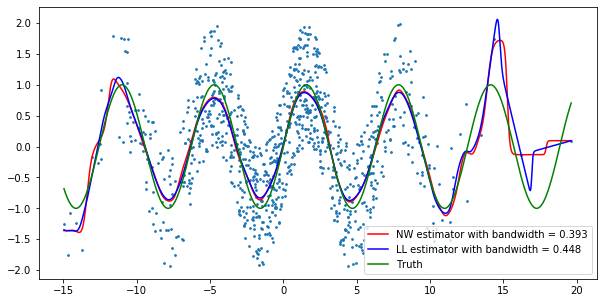

In [15]:
plt.figure(figsize = (10,5))

x_range = np.linspace(min(X), max(X), 10000)
pred_LL = LL_reg.fit(x_range)
pred = NW_reg.fit(x_range)
true = np.sin(x_range).ravel()

plt.scatter(X, y, s = 3)
plt.plot(x_range, pred[0], c = 'r',  label = 'NW estimator with bandwidth = %.3f' % NW_reg.bw)
plt.plot(x_range, pred_LL[0], c = 'b',  label = 'LL estimator with bandwidth = %.3f' % LL_reg.bw)
plt.plot(x_range, true, c = 'g',  label = 'Truth')
plt.legend();